# MINI-BATCH K-MEANS: STOCHASTIC OPTIMIZATION

FOR VERY LARGE DATASETS, STANDARD K-MEANS IS COMPUTATIONALLY EXPENSIVE BECAUSE IT REQUIRES CALCULATING DISTANCES TO ALL DATA POINTS IN EVERY ITERATION.

**MINI-BATCH K-MEANS** SOLVES THIS BY UPDATING CENTROIDS USING SMALL, RANDOM SUBSETS (BATCHES) OF THE DATA AT EACH STEP.

### ALGORITHM
1.  **INITIALIZE** CENTROIDS.
2.  **LOOP** FOR A FIXED NUMBER OF ITERATIONS:
    * SAMPLE A RANDOM BATCH $B$ OF SIZE $b$.
    * ASSIGN POINTS IN $B$ TO NEAREST CENTROIDS.
    * UPDATE CENTROIDS USING A PER-CENTER LEARNING RATE.

### UPDATE RULE (MOVING AVERAGE)
INSTEAD OF RE-CALCULATING THE MEAN FROM SCRATCH, WE UPDATE THE CENTROID $C$ AS A RUNNING AVERAGE:

$$C_{new} = (1 - \eta) C_{old} + \eta x$$

WHERE $\eta$ (LEARNING RATE) IS TYPICALLY THE INVERSE OF THE COUNT OF POINTS ASSIGNED TO THAT CLUSTER SO FAR.

## OBJECTIVES:
- REDUCE COMPUTATIONAL COST
- ENABLE SCALABILITY TO LARGE DATASETS
- MAINTAIN APPROXIMATE CLUSTER QUALITY

## IMPORTS & SETUP

### LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

### VISUALIZATION CONFIGURATION

In [3]:
# SETTING GLOBAL PARAMS TO ENSURE ALL PLOTS FOLLOW THE REQUIRED STYLE
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

def enforce_bold_ticks(ax):
    """
    HELPER FUNCTION TO ENSURE TICKS ARE BOLD.
    """
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

print("LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.")

LIBRARIES LOADED. VISUALIZATION STYLE CONFIGURED.


## DATA LOADING AND EXPLORATION

In [4]:
# LOAD DATASET
FILE_PATH = 'DATA/DATA.csv'
df = pd.read_csv(FILE_PATH)

# EXTRACT FEATURES AS NUMPY ARRAY
X_raw = df[['x1', 'x2']].values

## DATA PREPROCESSING

In [5]:
class StandardScaler:
    """
    IMPLEMENTS Z-SCORE NORMALIZATION.
    """
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        """
        COMPUTES MEAN AND STD, THEN SCALES THE DATA.
        """
        
        # CALCULATE MEAN AND STD ALONG AXIS 0 (COLUMNS)
        self.mean = np.mean(X, axis = 0)
        self.std = np.std(X, axis = 0)
        
        # PREVENT DIVISION BY ZERO
        eps = 1e-15
        self.std[self.std < eps] = eps
        
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X_scaled):
        """
        REVERTS SCALING TO ORIGINAL SPACE FOR VISUALIZATION.
        """
        
        return (X_scaled * self.std) + self.mean

In [6]:
# APPLY SCALING

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

## K-MEANS

In [7]:
class KMeans:
    """
    K-MEANS CLUSTERING IMPLEMENTATION FROM SCRATCH.
    
    ATTRIBUTES:
    -----------
    CENTROIDS : NUMPY ARRAY
        COORDINATES OF CLUSTER CENTERS.
    LABELS : NUMPY ARRAY
        CLUSTER INDEX FOR EACH DATA POINT.
    INERTIA_HISTORY : LIST
        STORES LOSS (WCSS) AT EACH ITERATION.
    FINAL_INERTIA : FLOAT
        FINAL LOSS VALUE AFTER CONVERGENCE.
    ITERATIONS_RUN : INT
        NUMBER OF ITERATIONS EXECUTED.
    """
    def __init__(self, k = 3, max_iter = 100, tol = 1e-4, metric = 'Euclidean', random_state = 36):
        """
        INITIALIZES HYPERPARAMETERS.
        
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        MAX_ITER : INT
            MAXIMUM OPTIMIZATION LOOPS.
        TOL : FLOAT
            CONVERGENCE TOLERANCE (EPSILON).
        METRIC : STR
            DISTANCE METRIC ('EUCLIDEAN', 'MANHATTAN', 'COSINE').
        RANDOM_STATE : INT
            SEED FOR REPRODUCIBILITY.
        """
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.metric = metric
        self.random_state = random_state
        
        self.centroids = None
        self.labels = None
        self.inertia_history = []
        self.final_inertia = None
        self.iterations_run = 0
    
    def initialize_centroids(self, X):
        """
        RANDOMLY SELECTS K DATA POINTS AS INITIAL CENTROIDS.
        """
        
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        
        return X[indices[:self.k]]
    
    def _euclidean_distance(self, X, centroid):
        """
        EUCLIDEAN DISTANCE: ||x - y||_2
        """
        
        return np.sqrt(np.sum((X - centroid) ** 2, axis = 1))

    def _manhattan_distance(self, X, centroid):
        """
        MANHATTAN DISTANCE: ||x - y||_1
        """
        
        return np.sum(np.abs(X - centroid), axis=1)

    def _cosine_distance(self, X, centroid):
        """
        COSINE DISTANCE = 1 - COSINE SIMILARITY
        """
        
        norm_X = np.linalg.norm(X, axis=1)
        norm_c = np.linalg.norm(centroid)
                
        # AVOID DIVISION BY ZERO
        denominator = norm_X * norm_c
        denominator[denominator == 0] = 1e-15
                
        dot_product = np.dot(X, centroid)
        similarity = dot_product / denominator
        
        return 1 - similarity
    
    def compute_distance(self, X, centroids):
        """
        COMPUTES DISTANCE MATRIX BETWEEN ALL POINTS X AND ALL CENTROIDS.
        RETURNS MATRIX OF SHAPE (N_SAMPLES, K).
        """
        n_samples = X.shape[0]
        n_centroids = centroids.shape[0]
        distances = np.zeros((n_samples, n_centroids))
        
        for i in range(n_centroids):
            centroid = centroids[i]
            
            if self.metric == 'Euclidean':
                # EUCLIDEAN: SQRT OF SUM OF SQUARED DIFFERENCES
                
                dist = self._euclidean_distance(X, centroid)
            
            elif self.metric == 'Manhattan':
                # MANHATTAN: SUM OF ABSOLUTE DIFFERENCES
                
                dist = self._manhattan_distance(X, centroid) 
                
            elif self.metric == 'Cosine':
                # COSINE DISTANCE: 1 - COSINE SIMILARITY
                
                dist = self._manhattan_distance(X, centroid)
            
            else:
                raise ValueError("UNSUPPORTED DISTANCE METRIC")    
                
            distances[:, i] = dist
            
        return distances
    
    def assign_clusters(self, X):
        """
        ASSIGN EACH POINT TO NEAREST CENTROID.
        """
        
        if self.centroids is None:
            raise ValueError("MODEL HAS NOT BEEN FITTED YET!")
        
        distances = self.compute_distance(X, self.centroids)
        labels = np.argmin(distances, axis=1)
            
        return labels

    def update_centroids(self, X):
        """
        UPDATE CENTROIDS AS MEAN OF ASSIGNED POINTS.
        """
        
        new_centroids = np.zeros_like(self.centroids)

        for cluster_idx in range(self.k):
            cluster_points = X[self.labels == cluster_idx]
            
            if len(cluster_points) > 0:
                    new_centroids[cluster_idx] = np.mean(cluster_points, axis=0)
            
            else:
                # HANDLE ORPHAN CENTROIDS BY KEEPING THEM STATIC
                new_centroids[cluster_idx] = self.centroids[cluster_idx]
                
        return new_centroids        
    
    def compute_inertia(self, X, centroids, labels):
        """
        CALCULATES INERTIA (WITHIN-CLUSTER SUM OF SQUARES).
        STRICTLY USES SQUARED EUCLIDEAN DISTANCE FOR COST DEFINITION.
        """
        
        inertia = 0.0
        
        for i in range(self.k):
            cluster_points = X[labels == i]
            
            if len(cluster_points) > 0:
                diff = cluster_points - centroids[i]
                sq_dist = np.sum(diff**2)
                inertia += sq_dist
        
        return inertia
    
    def train(self, X):
        """
        TRAINING LOOP (EXPECTATION-MAXIMIZATION).
        """   
        
        start_time = time.time()                 
        
        # STEP 1: INITIALIZATION
        self.centroids = self.initialize_centroids(X)
        self.inertia_history = []
        
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            
            # STEP 2: ASSIGNMENT (EXPECTATION STEP)
            self.labels = self.assign_clusters(X)
            
            # SAVE OLD CENTROIDS FOR CONVERGENCE CHECK
            old_centroids = self.centroids.copy()
            
            # STEP 3: UPDATE (MAXIMIZATION STEP)
            new_centroids = self.update_centroids(X)
            
            self.centroids = new_centroids
            
            # STEP 4: RECORD LOSS
            current_inertia = self.compute_inertia(X, self.centroids, self.labels)
            self.inertia_history.append(current_inertia)
            
            # STEP 5: CONVERGENCE CHECK
            centroid_shift = np.linalg.norm(self.centroids - old_centroids)
            if centroid_shift < self.tol:
                print(f"CONVERGED AT ITERATION {i+1}")
                break
        
        self.final_inertia = self.inertia_history[-1]   
        self.training_time = time.time() - start_time
        
    def predict(self, X):
        """
        ASSIGN CLUSTERS TO NEW DATA.
        """
        return self.assign_clusters(X)                 

## MODEL TRAINING

In [8]:
# DEFINE HYPERPARAMETERS
K_CLUSTERS = 3
MAX_ITERATIONS = 100
TOLERANCE = 1e-4
METRIC_TYPE = 'Euclidean'
SEED = 36

# INSTANTIATE AND TRAIN
model = KMeans(k=K_CLUSTERS, max_iter=MAX_ITERATIONS, tol=TOLERANCE, metric=METRIC_TYPE, random_state=SEED)

model.train(X_scaled)

CONVERGED AT ITERATION 4


## PERFORMANCE METRICS

In [9]:
print(f"ITERATIONS TO CONVERGENCE: {model.iterations_run}")
print(f"FINAL INERTIA: {model.final_inertia:.6f}")
print(f"TRAINING TIME (SECONDS): {model.training_time:.6f}")

ITERATIONS TO CONVERGENCE: 4
FINAL INERTIA: 19.020530
TRAINING TIME (SECONDS): 0.004009


In [10]:
# PREPARE DATA FOR PLOTTING (INVERSE TRANSFORM)
X_plot = scaler.inverse_transform(X_scaled)
centroids_plot = scaler.inverse_transform(model.centroids)

## MINI-BATCH K-MEANS CLASS IMPLEMENTATION

In [14]:
class MiniBatchKMeans:
    """
    MINI-BATCH K-MEANS IMPLEMENTATION.
    USES STOCHASTIC UPDATES FOR SCALABILITY.
    
    ATTRIBUTES:
    -----------
    CENTROIDS : NUMPY ARRAY
        CURRENT CLUSTER CENTERS.
    COUNTS : NUMPY ARRAY
        NUMBER OF POINTS ASSIGNED TO EACH CLUSTER OVER TIME.
    INERTIA_HISTORY : LIST
        LOSS ESTIMATES AT EACH STEP.
    
    PARAMETERS:
    -----------
    k : INT
        NUMBER OF CLUSTERS
    batch_size : INT
        NUMBER OF SAMPLES PER MINI-BATCH
    max_iter : INT
        NUMBER OF MINI-BATCH UPDATES
    tol : FLOAT
        CONVERGENCE THRESHOLD
    random_seed : INT
        RANDOM INITIALIZATION SEED    
    """
    
    def __init__(self, k=3, batch_size=10, max_iter=100, tol=1e-4, random_state=36):
        """
        ARGS:
        -----
        K : INT
            NUMBER OF CLUSTERS.
        BATCH_SIZE : INT
            SIZE OF RANDOM SUBSETS USED FOR UPDATES.
        MAX_ITER : INT
            NUMBER OF BATCH UPDATES TO PERFORM.
        TOL : FLOAT
            CONVERGENCE TOLERANCE (BASED ON CENTROID MOVEMENT).
        RANDOM_STATE : INT
            SEED FOR REPRODUCIBILITY.
        """
        
        self.k = k
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
        self.counts = None
        self.inertia_history = []
        self.iterations_run = 0
        
    def initialize_centroids(self, X):
        """
        RANDOMLY SELECTS K DATA POINTS AS INITIAL CENTROIDS.
        """
        
        np.random.seed(self.random_state)
        indices = np.random.permutation(X.shape[0])
        return X[indices[:self.k]]
    
    def euclidean_distance(self, X, centroid):
        """
        EUCLIDEAN DISTANCE: ||x - y||_2
        """
        
        return np.sqrt(np.sum((X - centroid) ** 2, axis = 1))
    
    def compute_distance(self, X, centroids):
        """
        COMPUTES EUCLIDEAN DISTANCE (VECTORIZED).
        """
        
        n_samples = X.shape[0]
        n_centroids = centroids.shape[0]
        distances = np.zeros((n_samples, n_centroids))

        for i in range(n_centroids):
            centroid = centroids[i]
            dist = self.euclidean_distance(X, centroid)
            distances[:, i] = dist
            
        return distances
    
    def assign_clusters(self, X):
        """
        ASSIGN EACH MINI-BATCH POINT TO NEAREST CENTROID.
        """
        
        if self.centroids is None:
            raise ValueError("MODEL HAS NOT BEEN FITTED YET!")
        
        distances = self.compute_distance(X, self.centroids)
        labels = np.argmin(distances, axis=1)
            
        return labels
    
    def update_centroids(self, X_batch, labels):
        """
        UPDATE CENTROIDS USING STOCHASTIC AVERAGING.

        FORMULA:
        c_new = c_old + (1 / n_c) * (x - c_old)
        """
     
        # UPDATE CENTROIDS
        for j in range(self.k):
            # FIND POINTS IN BATCH BELONGING TO CLUSTER J
            cluster_points = X_batch[labels == j]
                
            if len(cluster_points) > 0:
                # COUNT POINTS IN THIS BATCH FOR THIS CLUSTER
                count_batch = len(cluster_points)
                mean_batch = np.mean(cluster_points, axis = 0)
                    
                # UPDATE GLOBAL COUNT
                self.counts[j] += count_batch
                    
                # CALCULATE LEARNING RATE (ETA)
                # ETA = N_BATCH / N_TOTAL_SO_FAR
                # THIS IS EQUIVALENT TO UPDATING THE RUNNING MEAN
                    
                learning_rate = count_batch / self.counts[j]
                    
                # UPDATE CENTROID: (1-eta)*OLD + eta*NEW
                self.centroids[j] = (1 - learning_rate) * self.centroids[j] + learning_rate * mean_batch   

    def compute_inertia(self, X_batch, labels):
        """
        COMPUTE FULL DATASET INERTIA FOR MONITORING.
        """
        # TRACK APPROXIMATE INERTIA (ON BATCH)
        # CALCULATING EXACT INERTIA ON FULL DATA IS TOO SLOW FOR MINI-BATCH
        batch_inertia = 0
        for j in range(self.k):
            cluster_points = X_batch[labels == j]
            if len(cluster_points) > 0:
                batch_inertia += np.sum((cluster_points - self.centroids[j])**2)
        
        self.inertia_history.append(batch_inertia)

    
    def train(self, X):
        """
        TRAINS THE MODEL USING MINI-BATCH STOCHASTIC UPDATES.
        """
        
        start_time = time.time()
        n_samples = X.shape[0]
        
        # INITIALIZATION
        self.centroids = self.initialize_centroids(X)
        self.counts = np.zeros(self.k)
        self.inertia_history = []
        
        np.random.seed(self.random_state)
        
        # STOCHASTIC OPTIMIZATION LOOP
        for i in range(self.max_iter):
            self.iterations_run = i + 1
            
            # MANUAL BATCH SAMPLING
            # GENERATE RANDOM INDICES
            
            indices = np.random.choice(n_samples, self.batch_size, replace = False)
            X_batch = X[indices]
            
            labels = self.assign_clusters(X_batch)
            
            # STORE OLD CENTROIDS FOR CONVERGENCE CHECK
            old_centroids = self.centroids.copy()
            
            self.update_centroids(X_batch, labels)
                    
            self.compute_inertia(X_batch, labels)

            # CONVERGENCE CHECK
            shift = np.linalg.norm(self.centroids - old_centroids)
            
            if shift < self.tol:
                print(f"MINI-BATCH CONVERGED AT ITERATION {i}")
                break
            
        self.training_time = time.time() - start_time    

    def predict(self, X):
        """
        ASSIGNS NEW POINTS TO FINAL CENTROIDS.
        """
        
        distances = self.compute_distance(X, self.centroids)
        return np.argmin(distances, axis=1)

## MINI-BATCH PERFORMANCE & VISUALIZATION

WE TEST THE `MINIBATCHKMEANS` IMPLEMENTATION. NOTE THAT THE LOSS CURVE WILL BE **NOISY** BECAUSE IT IS CALCULATED ON RANDOM BATCHES, NOT THE FULL DATASET.

## TRAINING MINI-BATCH K-MEANS

In [17]:
# PARAMETERS
BATCH_SIZE = 32

# MORE ITERATIONS OFTEN NEEDED FOR STOCHASTIC METHODS
MAX_UPDATES = 200

# TRAIN MINI-BATCH MODEL
model_mini = MiniBatchKMeans(k=3, 
                            batch_size=BATCH_SIZE, 
                            max_iter=MAX_UPDATES, 
                            random_state=36)
model_mini.train(X_scaled)

# PREDICT LABELS ON FULL DATASET
labels_mini = model_mini.predict(X_scaled)

## MINI-BATCH K-MEANS CLUSTER VISUALIZATION

In [19]:
# INVERSE TRANSFORM FOR PLOTTING
X_plot_mb = scaler.inverse_transform(X_scaled)
C_plot_mb = scaler.inverse_transform(model_mini.centroids)

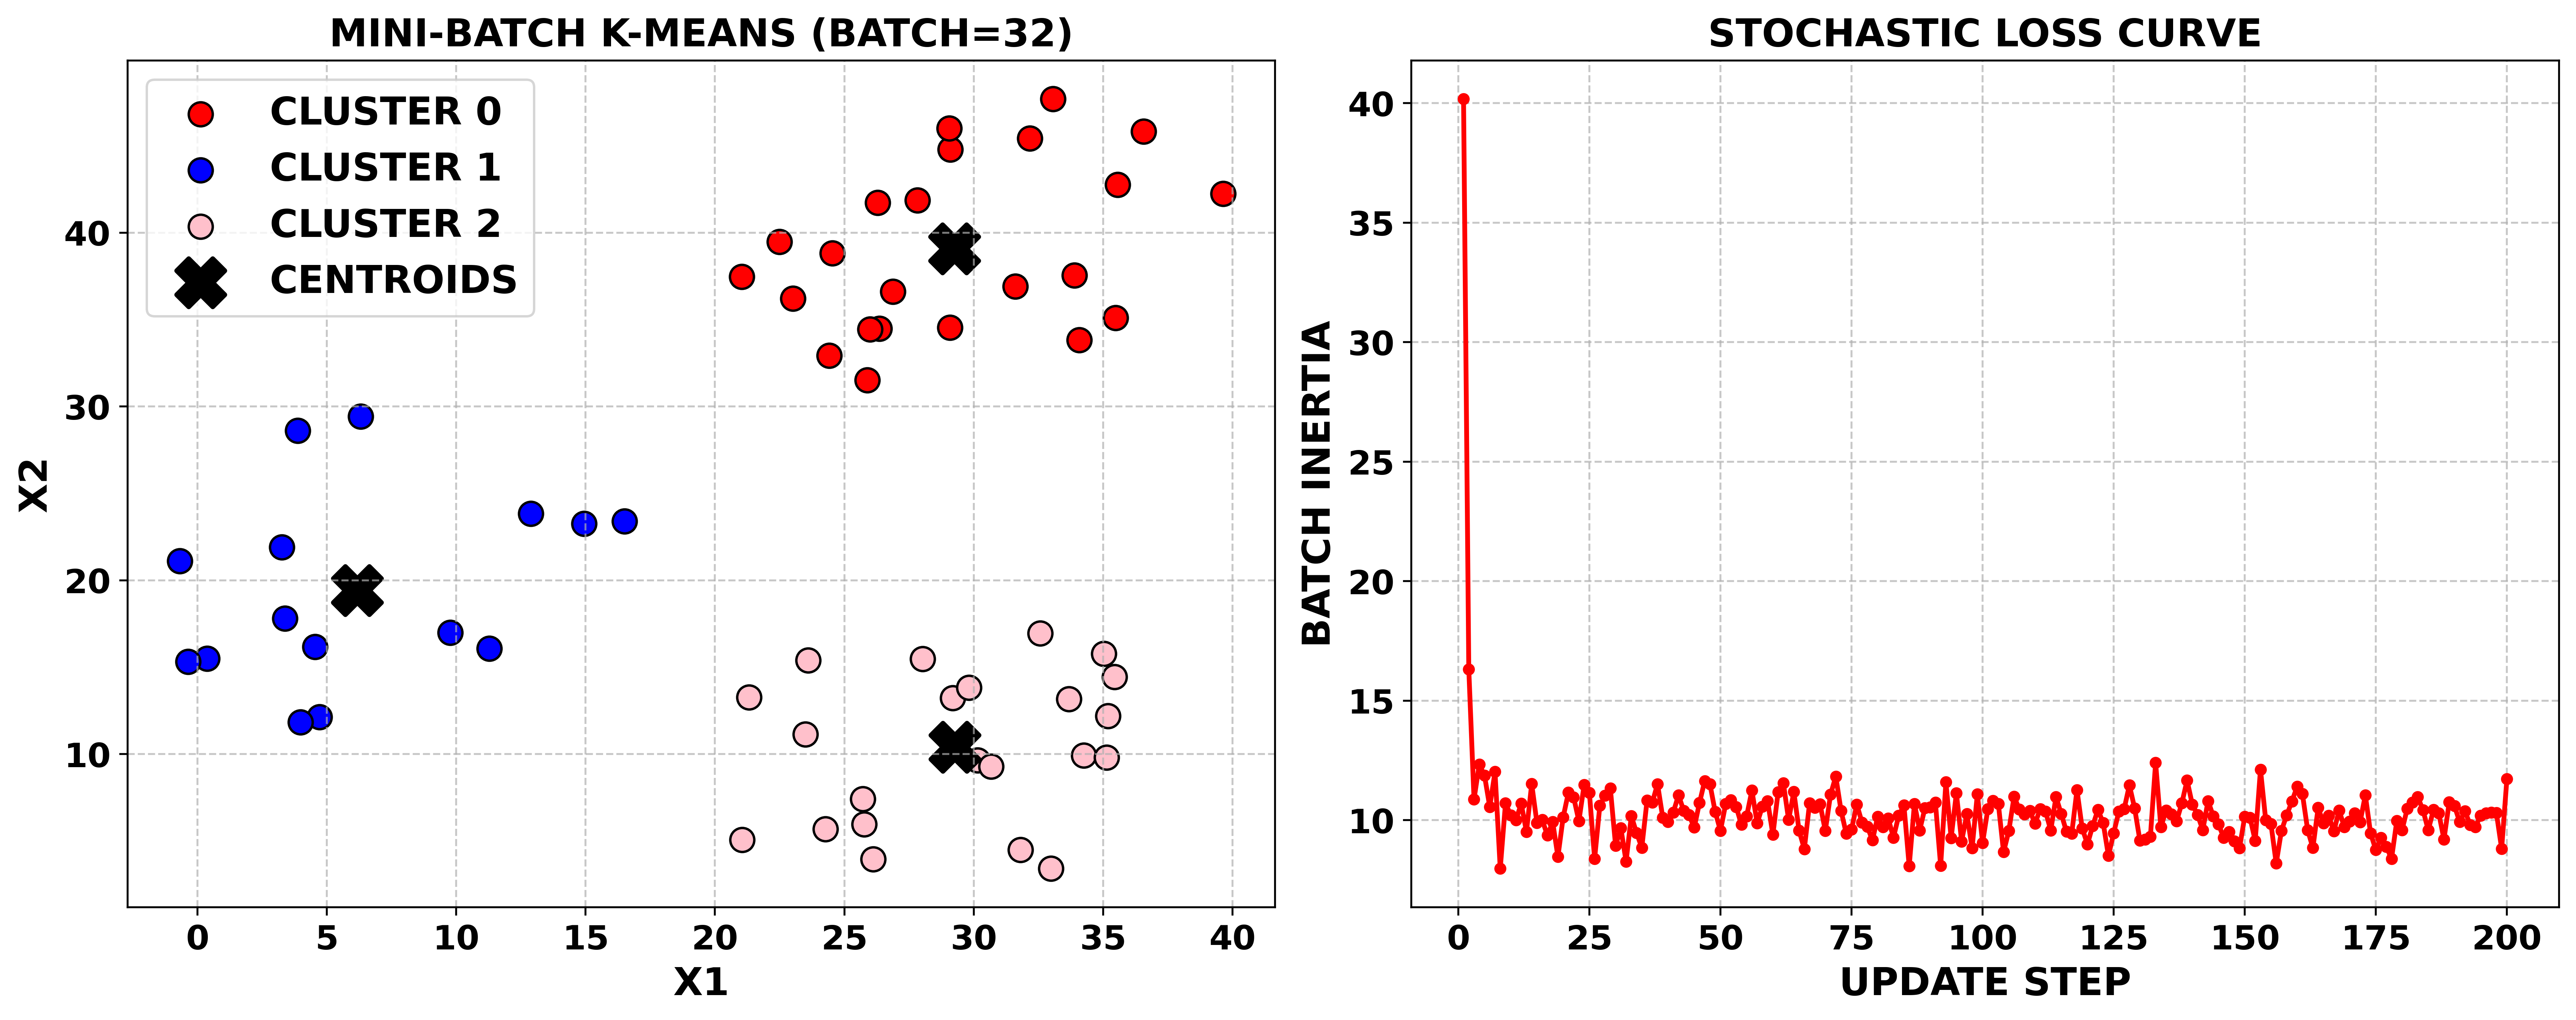

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi=500)

# VISUALIZE CLUSTERS
ax_1 = axes[0]

# PLOT CLUSTERS
colors = ['red', 'blue', 'pink', 'cyan', 'purple', 'grey', 'gold']
unique_labels = np.unique(labels_mini)

for i, label in enumerate(unique_labels):
    cluster_data = X_plot_mb[labels_mini == label]
    c = colors[i % len(colors)]
    ax_1.scatter(cluster_data[:, 0], cluster_data[:, 1], color=c, edgecolor='black', s=100, label=f"CLUSTER {label}")

# PLOT CENTROIDS
ax_1.scatter(C_plot_mb[:, 0], C_plot_mb[:, 1], color='black', marker='X', s=400, edgecolor='black', linewidth=2, label="CENTROIDS")    

ax_1.set_title(f"MINI-BATCH K-MEANS (BATCH={BATCH_SIZE})")
ax_1.set_xlabel("X1")
ax_1.set_ylabel("X2")
ax_1.legend(loc='upper left', frameon=True)
enforce_bold_ticks(ax_1)

# VISUALIZE STOCHASTIC LOSS
ax2 = axes[1]
ax2.plot(range(1, len(model_mini.inertia_history) + 1), model_mini.inertia_history, marker = 'o', color='red', linewidth = 2, markersize = 4)
ax2.set_title("STOCHASTIC LOSS CURVE")
ax2.set_xlabel("UPDATE STEP")
ax2.set_ylabel("BATCH INERTIA")
enforce_bold_ticks(ax2)

# ADJUST LAYOUT
plt.tight_layout()
plt.show()